In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [2]:
data_folder = './output/'
df = pd.read_csv(data_folder + 'df_final_changing_windows.csv')
#df.set_index('czas_utc', inplace=True)
df['czas_utc'] = pd.to_datetime(df['czas_utc'])
df.drop(df[df['koncentrat']==0].index, axis=0, inplace=True) #usunięcie wierszy z koncentratem=0
df.drop(['prob_corg_proc', 'prob_s_proc', 'prob_fe_proc', 'prazonka_s_proc', 'prazonka_fe_proc'], axis=1, inplace=True)
df.drop(['prazonka','prob_fe_masa','koncentrat','prob_s_masa','wymurowka_temp'], axis=1, inplace=True)
features = df.drop('temp_zuz',axis=1).diff()
features['prev_temp_zuz'] = df['temp_zuz'].shift(1)

features = features.iloc[1:,:]
label = df['temp_zuz'].iloc[1:,]

features['czas_utc'] = features['czas_utc'].dt.seconds/3600
#features = df.drop("temp_zuz", axis=1)
#label = df["temp_zuz"]

In [3]:
# wyszukanie najlepszych hyper parametrów dla lasów losowych
grid_values = {'min_samples_leaf': np.arange(20,51,10), 'max_depth': np.arange(2,16,1)}
grid_rf = GridSearchCV(RandomForestRegressor(n_estimators = 10, random_state=2137), param_grid = grid_values,scoring = 'r2')

grid_rf.fit(features, label)
params_rf = grid_rf.best_params_
print("Best parameters for RF:", grid_rf.best_params_)

Best parameters for RF: {'max_depth': 12, 'min_samples_leaf': 20}


In [4]:
# wyszukanie najlepszych hyper parametrów dla Gradient boostingu
gbr_params = {'n_estimators': [10],
          'max_depth': np.arange(2,16,1),
          'min_samples_split': np.arange(20,51,10)}

clf = GridSearchCV(estimator=GradientBoostingRegressor(random_state=2137), 
                   param_grid=gbr_params)
clf.fit(features, label)

print("Best parameters for gbr:", clf.best_params_)
params_gbr = clf.best_params_

Best parameters for gbr: {'max_depth': 12, 'min_samples_split': 20, 'n_estimators': 10}


In [5]:
X_test, X_train, y_test, y_train = train_test_split(features, label, test_size=0.2, random_state=2137)

# lasy losowe
rf = RandomForestRegressor(n_estimators = 10, min_samples_leaf=params_rf['min_samples_leaf'], 
                           max_depth=params_rf['max_depth'], random_state=2137)
# dopasownie do danych treningowych
rf.fit(X_train, y_train)

# predykcja danych treningowych
predictions_rf = rf.predict(X_train)
errors_rf = abs(predictions_rf - y_train)
mse_rf = mean_squared_error(y_train, predictions_rf)

In [6]:
# Gradient boosting
gbr = GradientBoostingRegressor(random_state=2137, max_depth=params_gbr['max_depth'], 
                                n_estimators=params_gbr['n_estimators'],
                                min_samples_split=params_gbr['min_samples_split'])
# dopasownie do danych treningowych
gbr.fit(X_train, y_train)
# predykcja danych treningowych
predictions_gbr = gbr.predict(X_train)
errors_gbr = abs(predictions_gbr - y_train)
mse_gbr = mean_squared_error(y_train, predictions_gbr)

In [7]:
X_test, X_train, y_test, y_train = train_test_split(features, label, test_size=0.2, random_state=2137)
# regresja liniowa
lr = LinearRegression()
# dopasownie do danych treningowych
lr.fit(X_train, y_train)
# predykcja danych treningowych
predictions_lr = lr.predict(X_train)
errors_lr = abs(predictions_lr - y_train)
mse_lr = mean_squared_error(y_train, predictions_lr)

Text(0.5, 1.0, 'Train data')

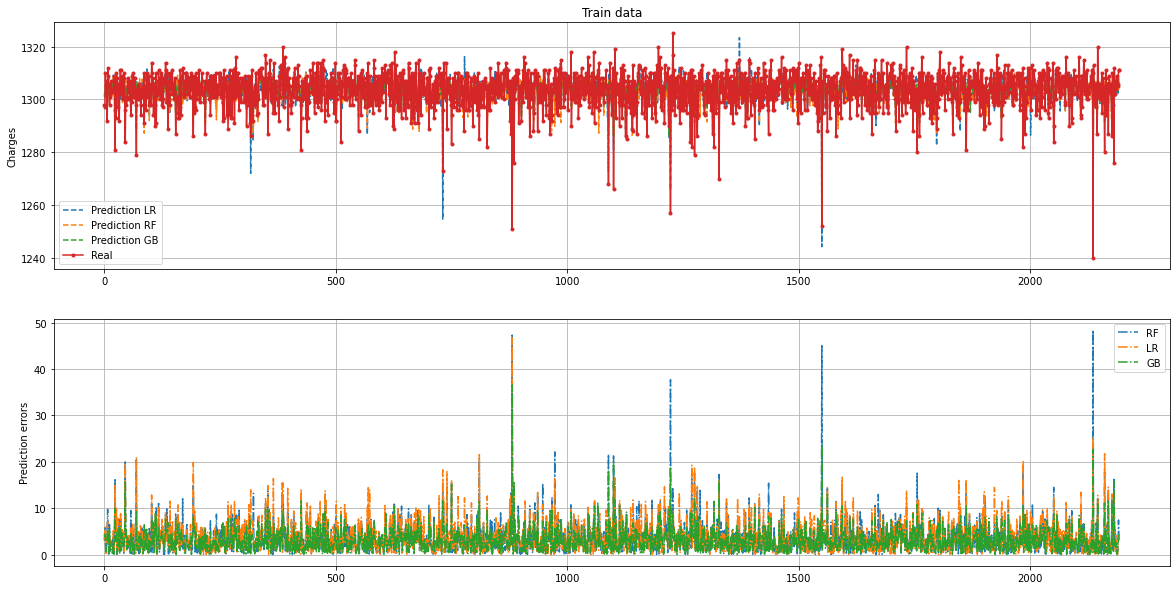

In [8]:
# plotowanie rezultatów dla danych treningowych
plt.rcParams["figure.figsize"] = (20,10)
x = range(len(y_train))
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(x, predictions_lr, linestyle='--', label='Prediction LR')
ax1.plot(x, predictions_rf, linestyle='--', label='Prediction RF')
ax1.plot(x, predictions_gbr, linestyle='--', label='Prediction GB')
ax1.plot(x, y_train, marker='.', label='Real')
ax1.set_ylabel('Charges')
ax1.legend()
ax1.grid()

ax2.plot(x, errors_rf, linestyle='-.', label='RF')
ax2.plot(x, errors_lr, linestyle='-.', label='LR')
ax2.plot(x, errors_gbr, linestyle='-.', label='GB')
ax2.set_ylabel('Prediction errors')
ax2.legend()
ax2.grid()
ax1.set_title('Train data')

R^2 for train data for RF = 0.46 
R^2 for test data for RF = 0.32 
R^2 for train data for LR = 0.43 
R^2 for test data for LR = 0.42 
R^2 for train data for GB = 0.66 
R^2 for test data for GB = 0.30 
MSE for train data for RF = 25.39 
MSE for test data for RF = 32.80 
MSE for train data for LR = 26.75 
MSE for test data for LR = 27.99 
MSE for train data for GB = 16.06 
MSE for test data for GB = 33.40 


Text(0.5, 1.0, 'Test data')

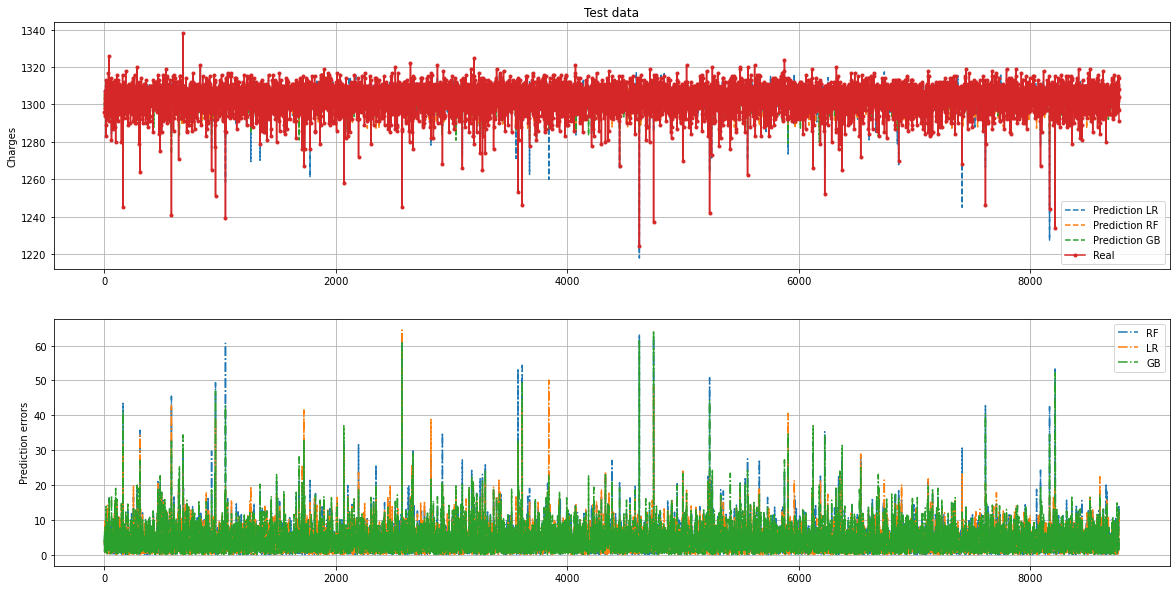

In [10]:
# plotowanie rezultatów dla danych testowych
predictions_rf = rf.predict(X_test)
errors_rf = abs(predictions_rf - y_test)
predictions_lr = lr.predict(X_test)
errors_lr = abs(predictions_lr - y_test)
predictions_gbr = gbr.predict(X_test)
errors_gbr = abs(predictions_gbr - y_test)
print('R^2 for train data for RF = %.2f ' %rf.score(X_train,y_train))
print('R^2 for test data for RF = %.2f ' %rf.score(X_test,y_test))
print('R^2 for train data for LR = %.2f ' %lr.score(X_train,y_train))
print('R^2 for test data for LR = %.2f '%lr.score(X_test,y_test))
print('R^2 for train data for GB = %.2f ' %gbr.score(X_train,y_train))
print('R^2 for test data for GB = %.2f '%gbr.score(X_test,y_test))

print('MSE for train data for RF = %.2f ' %mse_rf)
print('MSE for test data for RF = %.2f ' %mean_squared_error(y_test, predictions_rf))
print('MSE for train data for LR = %.2f ' %mse_lr)
print('MSE for test data for LR = %.2f '% mean_squared_error(y_test, predictions_lr))
print('MSE for train data for GB = %.2f ' %mse_gbr)
print('MSE for test data for GB = %.2f '%mean_squared_error(y_test, predictions_gbr))


x = range(len(y_test))
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(x, predictions_lr, linestyle='--', label='Prediction LR')
ax1.plot(x, predictions_rf, linestyle='--', label='Prediction RF')
ax1.plot(x, predictions_gbr, linestyle='--', label='Prediction GB')
ax1.plot(x, y_test, marker='.', label='Real')
ax1.set_ylabel('Charges')
ax1.legend()
ax1.grid()

ax2.plot(x, errors_rf, linestyle='-.', label='RF')
ax2.plot(x, errors_lr, linestyle='-.', label='LR')
ax2.plot(x, errors_gbr, linestyle='-.', label='GB')
ax2.set_ylabel('Prediction errors')
ax2.legend()
ax2.grid()

ax1.set_title('Test data')

In [11]:
imp = pd.DataFrame({'column': features.columns.values, 'RF_importance': rf.feature_importances_,
              'GB_importance': gbr.feature_importances_}).sort_values('RF_importance', ascending=False)
imp

,column,RF_importance,GB_importance
11,prev_temp_zuz,0.580203,0.399854
9,moc_cieplna_odebrana,0.081603,0.082413
4,pyl,0.080644,0.119586
7,prazonka_s_masa,0.070244,0.054823
6,prazonka_fe_masa,0.041363,0.085510
3,woda_zasil_temp,0.034090,0.044420
2,woda_powrotna_temp,0.032323,0.040543
5,prob_corg_masa,0.024092,0.034411
1,woda_powrotna_przeplyw,0.021829,0.027283
8,wentylator,0.018385,0.069709


In [12]:
x = {'prev_temp_zuz': 'Poprzednia temperatura', 'prazonka_fe_masa': 'Prazonka_fe_masa', 
     'moc_cieplna_odebrana': 'Moc cieplna odebrana', 'pyl': 'Pył', 'koncentrat': 'Koncentrat', 
     'woda_zasil_temp': 'Woda_zasil_temp', 'woda_powrotna_temp': 'Woda_powrotna_temp', 'prazonka_s_masa': 'Prażonka_S_masa',
    'wentylator': 'Wentylator ODCZ_ZAD OBROTÓW', 'kol_kan_temp': 'Temperatura na kol. kan.', 'czas_utc': 'Diff czas',
    'prob_corg_masa': 'Prob_corg_masa', 'prob_fe_masa': 'Prob_fe_masa', 'woda_powrotna_przeplyw': 'Woda_powrotna_przepływ',
     'wymurowka_temp': 'Temperatura wymurówka', 'prazonka': 'Prażonka', 'prob_s_masa': 'Prob_s_masa'}

In [13]:
imp['column'] = imp['column'].map(x)
imp.set_index('column')

,RF_importance,GB_importance
column,,
Poprzednia temperatura,0.580203,0.399854
Moc cieplna odebrana,0.081603,0.082413
Pył,0.080644,0.119586
Prażonka_S_masa,0.070244,0.054823
Prazonka_fe_masa,0.041363,0.085510
Woda_zasil_temp,0.034090,0.044420
Woda_powrotna_temp,0.032323,0.040543
Prob_corg_masa,0.024092,0.034411
Woda_powrotna_przepływ,0.021829,0.027283


In [15]:
# use differetn library to calculate p-values
mod = sm.OLS(list(y_train),X_train)
fii=mod.fit()
p_values=fii.summary2().tables[1]['P>|t|']
p_values
p = pd.DataFrame({'column': features.columns.values, 'p_values': np.round(p_values.values,3)}).sort_values('p_values', ascending=False)
p['column'] = p['column'].map(x)
p.set_index('column')

,p_values
column,
Prob_corg_masa,0.006
Prażonka_S_masa,0.001
Moc cieplna odebrana,0.001
Diff czas,0.000
Woda_powrotna_przepływ,0.000
Woda_powrotna_temp,0.000
Woda_zasil_temp,0.000
Pył,0.000
Prazonka_fe_masa,0.000


In [ ]:
#save model
filename = 'finalized_model.sav'
joblib.dump(lr, filename)